# Lateness

- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import lateness_scheduling as lp_lateness
import src.models.heuristics.fcfs as fcfs

# Extern
import pandas as pd
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60 * 6 # 6 min

In [3]:
basic_data_path = get_path("data", "basic")
day_count = 1

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 u_b_mmax= 0.94, shift_length=1440, shuffle=True,
                                                                 job_seed=40, arrival_seed=80)
df_job_times = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_job_times


Schedule-Informationen:
  Makespan: 2400


,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,49,848.0
1,1,1,130,1162.0
2,2,2,151,1300.0
3,3,3,226,1551.0
4,4,4,386,1181.0
5,5,5,464,1467.0
6,6,6,480,1322.0
7,7,7,506,1596.0
8,8,8,526,1734.0
9,9,9,535,1627.0


## a) Absolute Lateness Summe

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).



In [4]:
# Scheduling
df_schedule = lp_lateness.solve_jssp_sum(df_jssp, df_job_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.0)
df_schedule

BigM: 6000

Solver-Informationen:
  Summe absolute Lateness  : 33.0
  Solver-Status            : Optimal
  Anzahl Variablen         : 2140
  Anzahl Constraints       : 4040
  Laufzeit                 : ~94 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,0,0,0,49,848.0,M00,49.0,29.0,78.0,-770.0,770.0
1,0,0,1,49,848.0,M01,78.0,78.0,156.0,-692.0,692.0
2,1,1,0,130,1162.0,M00,130.0,43.0,173.0,-989.0,989.0
3,0,0,2,49,848.0,M02,156.0,9.0,165.0,-683.0,683.0
4,0,0,3,49,848.0,M03,165.0,36.0,201.0,-647.0,647.0
...,...,...,...,...,...,...,...,...,...,...,...
195,18,5,8,1397,2400.0,M04,2261.0,6.0,2267.0,-133.0,133.0
196,17,3,7,1285,2610.0,M03,2341.0,98.0,2439.0,-171.0,171.0
197,18,5,9,1397,2400.0,M07,2375.0,25.0,2400.0,0.0,0.0
198,17,3,8,1285,2610.0,M09,2439.0,22.0,2461.0,-149.0,149.0


In [5]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0              19
0 - 60          0
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int64


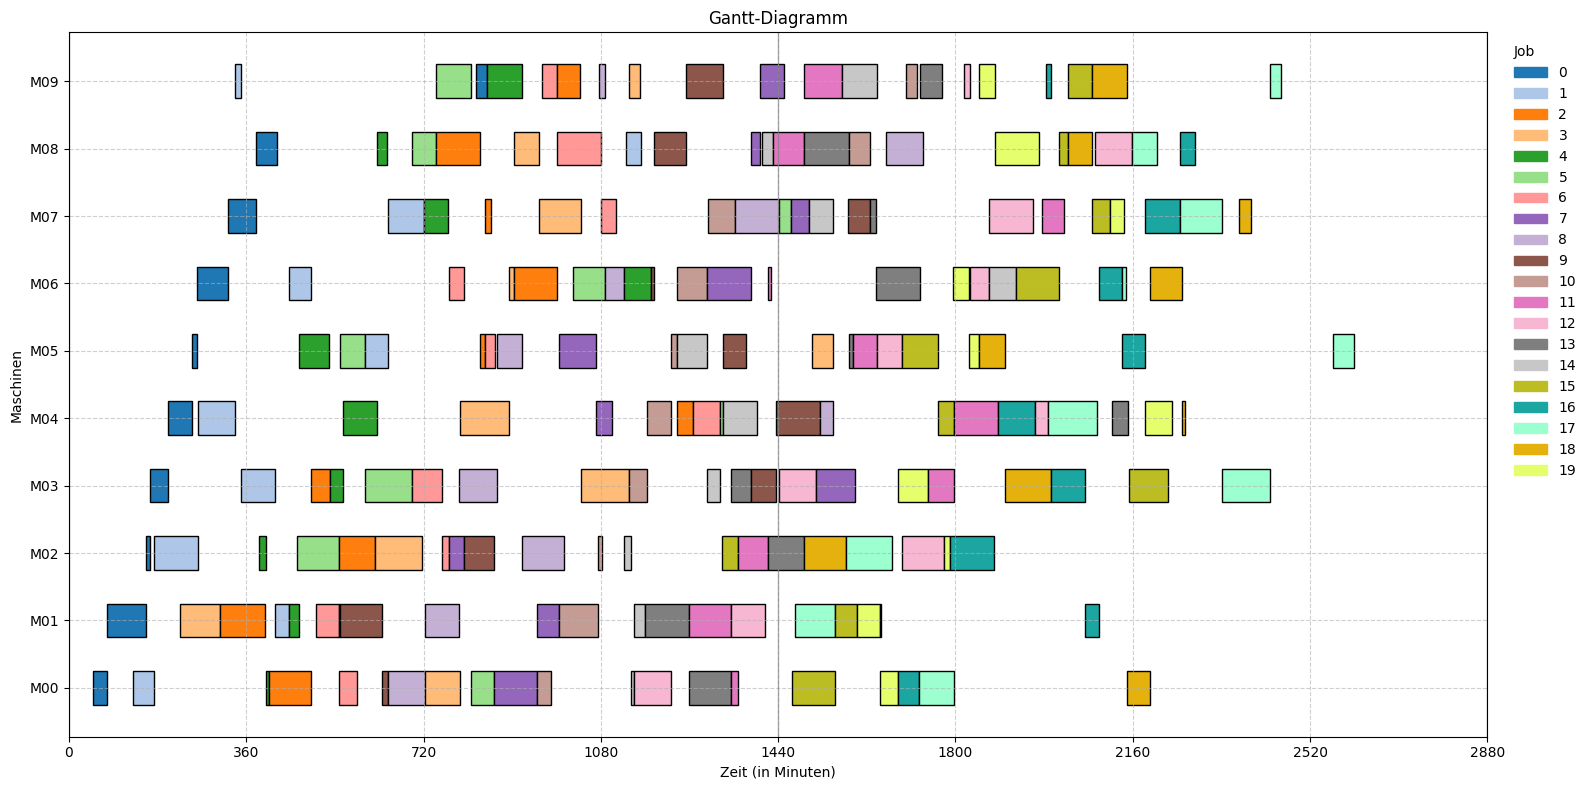

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [6]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## b) größte absolute Lateness minimieren

$$
\min \; \max_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **größte Abweichung** eines Jobs zur Deadline – unabhängig davon, ob der Job **zu früh oder zu spät** fertiggestellt wurde.  
Sie sorgt dafür, dass **kein Job extrem abweicht**, und behandelt **Früh- und Spätfertigstellungen gleichwertig**.


In [7]:
# Scheduling
df_schedule = lp_lateness.solve_jssp_max(df_jssp, df_job_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.0)
df_schedule

BigM: 6000

Solver-Informationen:
  Maximale absolute Lateness : 16.5
  Solver-Status              : Optimal
  Anzahl Variablen           : 2141
  Anzahl Constraints         : 4060
  Laufzeit                   : ~14 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,0,0,0,49,848.0,M00,49.0,29.0,78.0,-770.0,770.0
1,0,0,1,49,848.0,M01,78.0,78.0,156.0,-692.0,692.0
2,1,1,0,130,1162.0,M00,130.0,43.0,173.0,-989.0,989.0
3,0,0,2,49,848.0,M02,156.0,9.0,165.0,-683.0,683.0
4,0,0,3,49,848.0,M03,165.0,36.0,201.0,-647.0,647.0
...,...,...,...,...,...,...,...,...,...,...,...
195,18,5,8,1397,2400.0,M04,2373.5,6.0,2379.5,-20.5,20.5
196,18,5,9,1397,2400.0,M07,2379.5,25.0,2404.5,4.5,4.5
197,17,3,7,1285,2610.0,M03,2463.5,98.0,2561.5,-48.5,48.5
198,17,3,8,1285,2610.0,M09,2561.5,22.0,2583.5,-26.5,26.5


In [8]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0        11
0               2
0 - 60          7
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int64


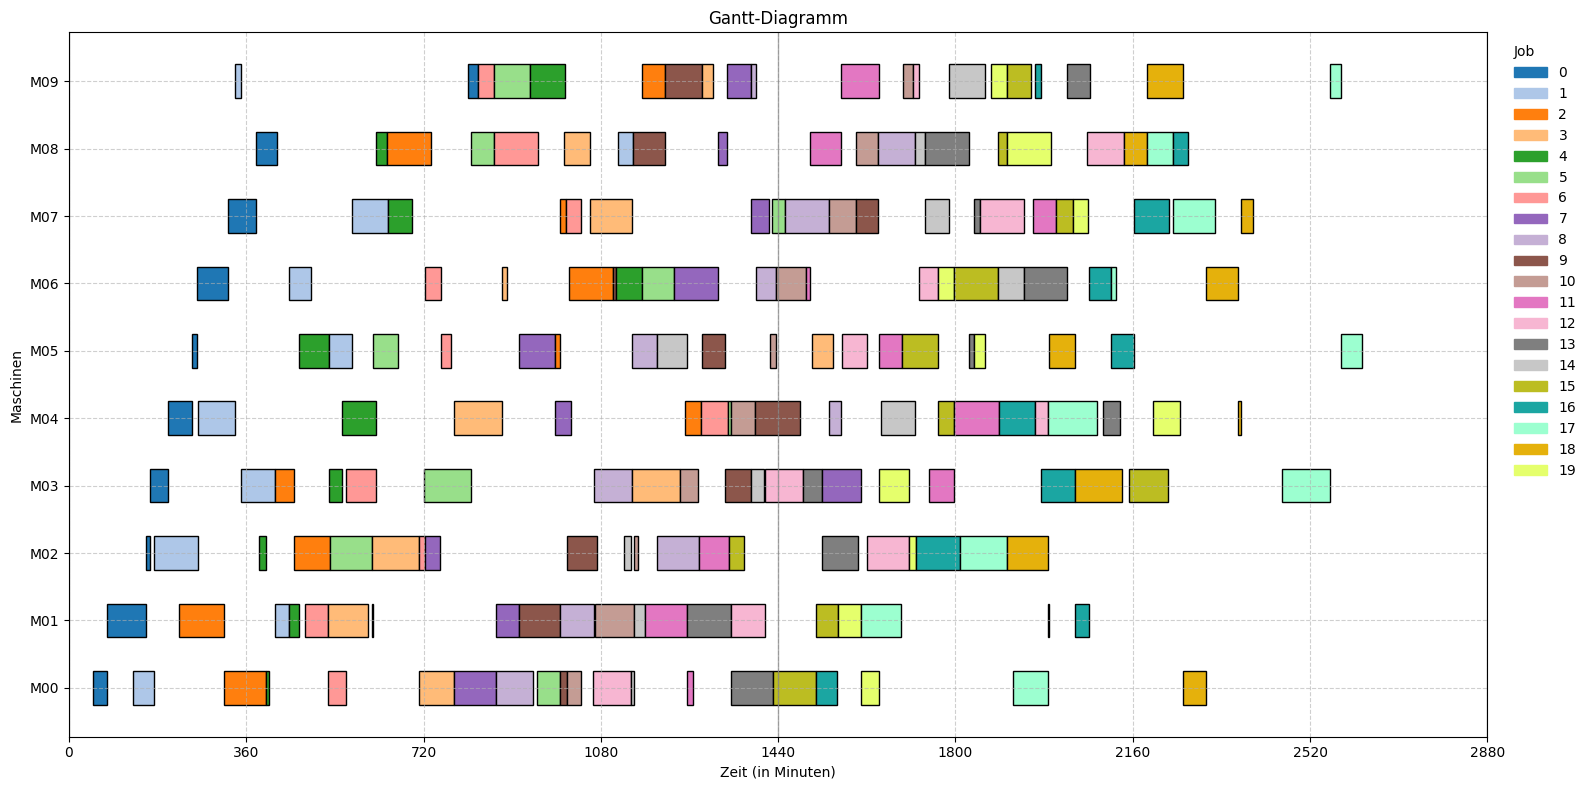

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [9]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)